In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio

from IPython.core.display import HTML
HTML(r"""
<style>
    .jp-MarkdownCell .jp-RenderedHTMLCommon {
        font-family: "Times New Roman", Times, serif;
        font-size: 20px
    }
</style>
""")


# H2 - EQ Design

Your task is to design and implement a two-band audio equaliser (i.e. a bass/treble basic tone control) using first-order shelving filters.

You will investigate the transfer function of the first-order low-pass shelving filter and its complementary high-pass form. Cascading both filter sections will then produce a two-band audio equaliser. You must decide the range of each frequency band and justify your choice. Use a fixed sampling frequency fs = 44.1 kHz in all your work. 

Your submission should include: 

1) A description of the equaliser’s architecture, including the transfer function of each shelving filter, the parameters selected, and a block diagram of each filter, as well as the overall system. Note that the block diagram should include the unit delays and taps (see the lecture notes for an example of what a filter block diagram should look like!).  It is not permitted to use the Matlab's filter design functions in the final submission.

2) Magnitude response plots for each individual filter as well as the combined response of the equaliser for different gain parameters. For example, set the bass and treble gains at GLP = 6 dB and GHP = −3 dB, respectively. What is the magnitude response of each filter? What about the overall output response? Modify the bass and gain levels, what does the response look like now? 

3) A Matlab implementation of the equaliser (thoroughly commented) and all required files to run the script. For example, if your script is using a wav file as input, it should be included.

4) References to any sources consulted for this work. 

All submitted plots must have all axes labelled. If you are plotting multiple responses in the same figure please use different line colours and Matlab’s legend function to indicate which line is which. All frequency-domain figures should be plotted using logarithmic scale for the x-axis and decibels for the y-axis.


# Low Shelving Filter

To prototype the filter, we first define these three point:
- $H(0) = G$ &nbsp; (DC)
- $H(-1) = 1$ &nbsp; (Nyquist)
- $|H(e^{j\omega_c})| = \sqrt{G}$ &nbsp; (cutoff frequency / crossover)

when $\omega_c = \pi/2$, $H(z) = \sqrt{G}\frac{z+p}{z-p}$

$H(-1) = 1 \quad \rightarrow \quad \sqrt{G}\frac{-1+p}{-1-p} = 1 \quad \rightarrow \quad p = \frac{G-\sqrt{G}}{G+\sqrt{G}}$

apply lowpass-to-lowpass transformation

$z \rightarrow \frac{z-\beta}{1-\beta z} \quad, \quad \beta = \frac{1-tan(\omega_c/2)}{1+tan(\omega_c/2)}$

therefore, the first order low shelf filter has the transfer function:

$H_{LS}(z) = \frac{b_0' + b_1' z^{-1}}{a_0' + a_1' z^{-1}} = \frac{b_0 + b_1 z^{-1}}{1+a_1z^{-1}}$ 

where,

$b_0' = \sqrt{G} + G tan(\omega_c/2)$

$b_1' = -\sqrt{G} + G tan(\omega_c/2)$

$a_0' = \sqrt{G} + tan(\omega_c/2)$

$a_1' = -\sqrt{G} + tan(\omega_c/2)$


![Alt text](1.svg)

In [19]:
fs = 44100 # Sampling frequency [Hz]

# define the 1st-order low shelf filter function
def lowShelf (gain, fc, fs):
    # INPUT:    gain
    #           fc : crossover (Hz)
    #           fs : sampling frequency (Hz)
    # OUTPUT:   b0, b1, a0, a1 : filter coefficient
    #           w, h : frequency response
    # USAGE:    b0_low, b1_low, a0_low, a1_low, w, h_low = lowShelf(gain, fc, fs)

    omega_c_low = 2 * np.pi * fc / fs
    G = 10**(gain/20) # Convert gain from dB to linear scale
    
    b0 = G * np.tan(omega_c_low/2) + np.sqrt(G)
    b1 = G * np.tan(omega_c_low/2) - np.sqrt(G)

    a0 = np.tan(omega_c_low/2) + np.sqrt(G)
    a1 = np.tan(omega_c_low/2) - np.sqrt(G) 
    
    w, h = signal.freqz([b0, b1], [a0, a1], fs)

    return b0, b1, a0, a1, w, h

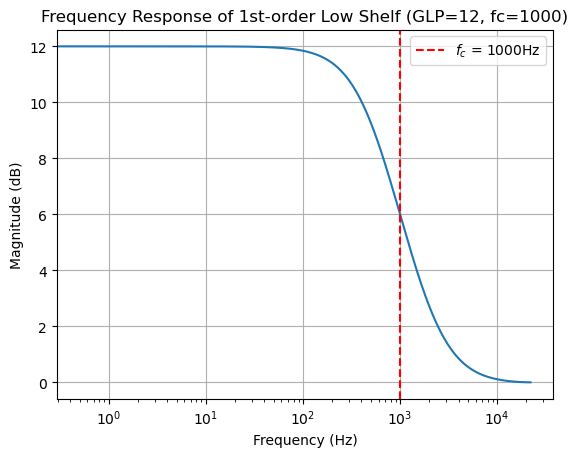

In [20]:
# Compute the frequency response
b0_low, b1_low, a0_low, a1_low, w, h_low = lowShelf(12, 1000, fs)

# Plot the frequency response
plt.figure()
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_low)))
plt.axvline(x=1000, color='r', linestyle='--', label='$f_c$ = 1000Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of 1st-order Low Shelf (GLP=12, fc=1000)')
plt.grid(True)
plt.legend()
plt.show()

### Magnitude responses of low-frequency shelving filters with complementary gains

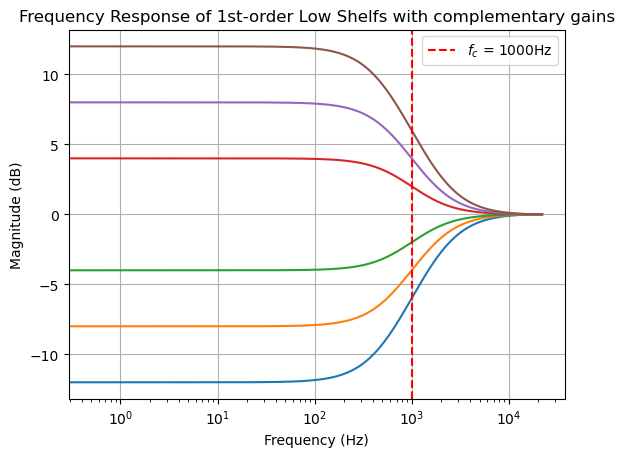

In [21]:
gain = [-12, -8, -4, 4, 8, 12]

plt.figure()
for g in gain:

    b0_low, b1_low, a0_low, a1_low, w, h_lows = lowShelf(g, 1000, fs)
    plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_lows)))

plt.axvline(x=1000, color='r', linestyle='--', label='$f_c$ = 1000Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of 1st-order Low Shelfs with complementary gains')
plt.grid(True)
plt.legend()

plt.show()

# High Shelving filter

The complementary high-frequency shelving filter can be obtained by replacing the gain G by 1/G. And then multiply the numerator by G. Additionally, we multiply both the numerator and the denominator by $\sqrt{G}$ to cancle divisions by G.[2]

$b_0' = \sqrt{G}(G\cdot(b_{0,low}')) = \sqrt{G} tan(\omega_c/2) + G$

$b_1' = \sqrt{G}(G\cdot (b_{1,low}')) = \sqrt{G} tan(\omega_c/2) - G$

$a_0' = \sqrt{G} \cdot a_{0, low}' = \sqrt{G} tan(\omega_c/2) + 1$

$a_1' = \sqrt{G} \cdot a_{1, low}' = \sqrt{G} tan(\omega_c/2) - 1$


In [22]:
# define the 1st-order high shelf filter function
def highShelf (gain, fc, fs):
    # INPUT:    gain
    #           fc : crossover (Hz)
    #           fs : sampling frequency (Hz)
    # OUTPUT:   b0, b1, a0, a1 : filter coefficient
    #           w, h : frequency response
    # USAGE:    b0_high, b1_high, a0_high, a1_high, w, h_high = highShelf(gain, fc, fs)

    omega_c_low = 2 * np.pi * fc / fs
    G = 10**(gain/20) # Convert gain from dB to linear scale
    
    b0 = np.sqrt(G) * np.tan(omega_c_low/2) + G
    b1 = np.sqrt(G) * np.tan(omega_c_low/2) - G

    a0 = np.sqrt(G) * np.tan(omega_c_low/2) + 1
    a1 = np.sqrt(G) * np.tan(omega_c_low/2) - 1
    
    w, h = signal.freqz([b0, b1], [a0, a1], fs)

    return b0, b1, a0, a1, w, h

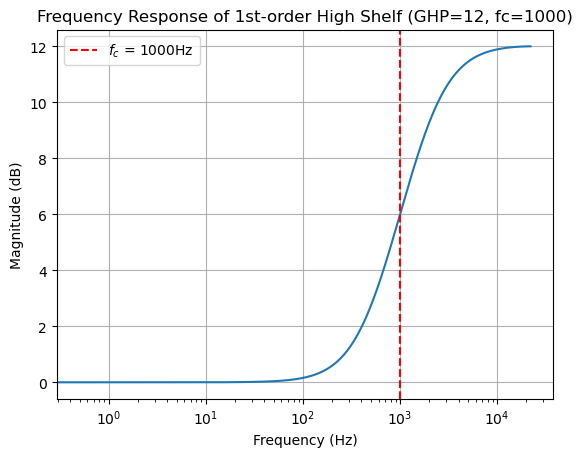

In [23]:
b0_high, b1_high, a0_high, a1_high, w, h_high = highShelf(12, 1000, fs)

# Plot the frequency response
plt.figure()
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_high)))
plt.axvline(x=1000, color='r', linestyle='--', label='$f_c$ = 1000Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of 1st-order High Shelf (GHP=12, fc=1000)')
plt.grid(True)
plt.legend()
plt.show()

# Cascade filter

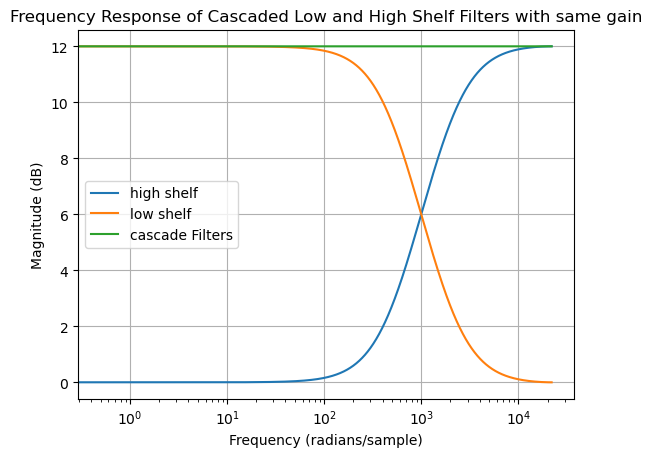

In [24]:
_, _, _, _, _, h_l = lowShelf(12, 1000, fs)
_, _, _, _, _, h_h = highShelf(12, 1000, fs)
h_cascade = h_l * h_h

# Plot the frequency response of the cascaded filters
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_h)), label='high shelf')
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_l)), label='low shelf')
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(abs(h_cascade)), label='cascade Filters')
plt.xlabel('Frequency (radians/sample)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of Cascaded Low and High Shelf Filters with same gain')
plt.legend()
plt.grid(True)
plt.show()

When low shelf and high shelf have the same crossover and gain, the cascade filter will produced a constant gain G across all frequencies.

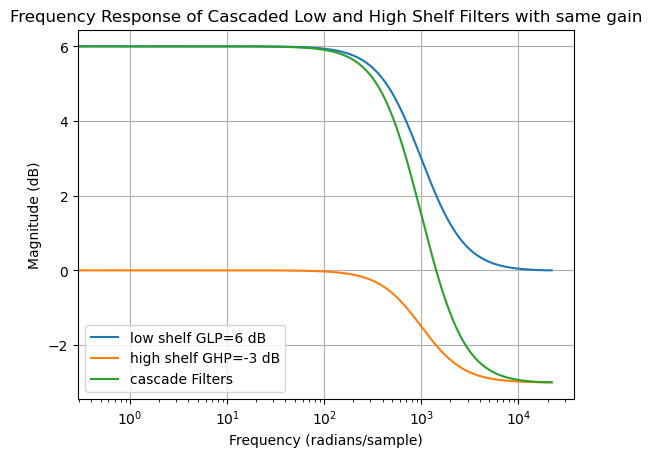

In [25]:
_, _, _, _, _, h_l = lowShelf(6, 1000, fs)
_, _, _, _, _, h_h = highShelf(-3, 1000, fs)
h_cascade = h_l * h_h

# Plot the frequency response of the cascaded filters
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_l)), label='low shelf GLP=6 dB')
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_h)), label='high shelf GHP=-3 dB')
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(abs(h_cascade)), label='cascade Filters')
plt.xlabel('Frequency (radians/sample)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of Cascaded Low and High Shelf Filters with same gain')
plt.legend()
plt.grid(True)
plt.show()

When the low shelf filter has a gain of 6 dB (GLP = 6 dB), it provides a boost of 6 dB for frequencies below the cutoff frequency (fc). while maintaining zero gain for higher frequencies. Conversely, when the high shelf filter has a gain of -3 dB (GHP = -3 dB), it induces a 3 dB attenuation for frequencies above fc, while preserving zero gain for lower frequencies.

Given that both filters share the same cutoff frequency (fc), their cascaded effect results in a 6 dB boost for frequencies below fc and a 3 dB attenuation for frequencies above fc.

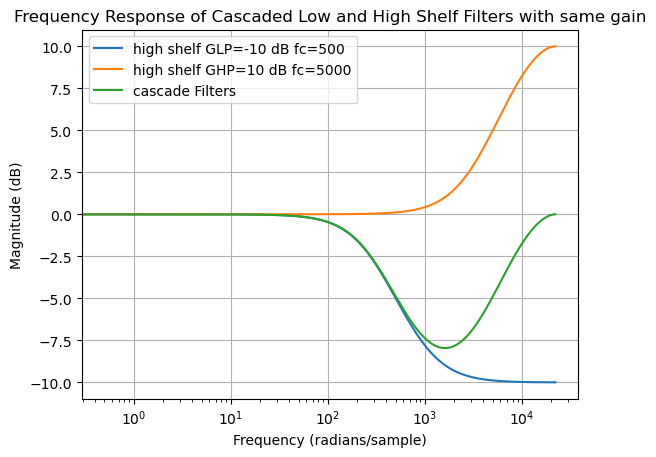

In [26]:
_, _, _, _, _, h_1 = highShelf(-10, 500, fs)
_, _, _, _, _, h_2 = highShelf(10, 5000, fs)
h_cascade = h_1 * h_2

# Plot the frequency response of the cascaded filters
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_1)), label='high shelf GLP=-10 dB fc=500')
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_2)), label='high shelf GHP=10 dB fc=5000')
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(abs(h_cascade)), label='cascade Filters')
plt.xlabel('Frequency (radians/sample)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of Cascaded Low and High Shelf Filters with same gain')
plt.legend()
plt.grid(True)
plt.show()

This combination of two high shelf filters with opposite gains and different crossover frequencies creates a notch filter effect.

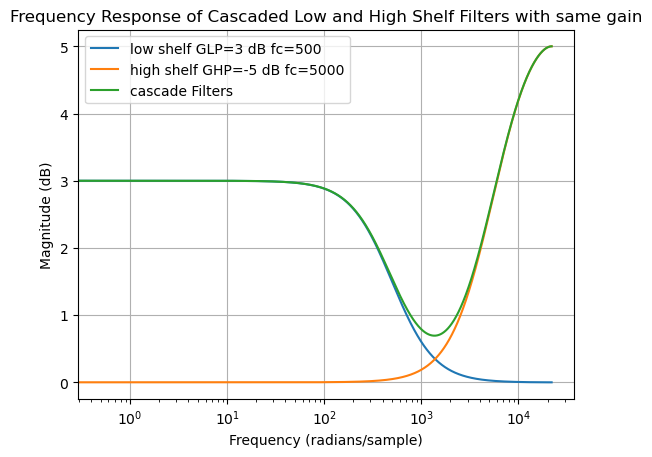

In [27]:
_, _, _, _, _, h_l = lowShelf(3, 500, fs)
_, _, _, _, _, h_h = highShelf(5, 5000, fs)
h_cascade = h_l * h_h

# Plot the frequency response of the cascaded filters
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_l)), label='low shelf GLP=3 dB fc=500')
plt.semilogx(w * fs / (2 * np.pi), 20 * np.log10(abs(h_h)), label='high shelf GHP=-5 dB fc=5000')
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(abs(h_cascade)), label='cascade Filters')
plt.xlabel('Frequency (radians/sample)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of Cascaded Low and High Shelf Filters with same gain')
plt.legend()
plt.grid(True)
plt.show()

If different gains are used, as in the configuration described above, where GLP ≠ GHP, in addition to the notch effect around the crossover frequency, there will also be a greater boost in high-frequency content.

This boost occurs because the gain applied by the high shelf filter (GHP) is greater than the gain applied by the low shelf filter (GLP). Specifically, if GHP > GLP, frequencies above the crossover frequency will experience a higher gain increase, resulting in a more pronounced boost in high-frequency content.

Therefore, in such a configuration, the resulting frequency response will exhibit a notch around the crossover frequency, where frequencies are attenuated, along with a stronger boost in high-frequency content beyond the crossover frequency, where frequencies are amplified even more.

# Sound Test

In [28]:
t = 5 # seconds
x = np.random.normal(0, 1, 5 * fs)
Audio(data = x*0.1, rate = fs)

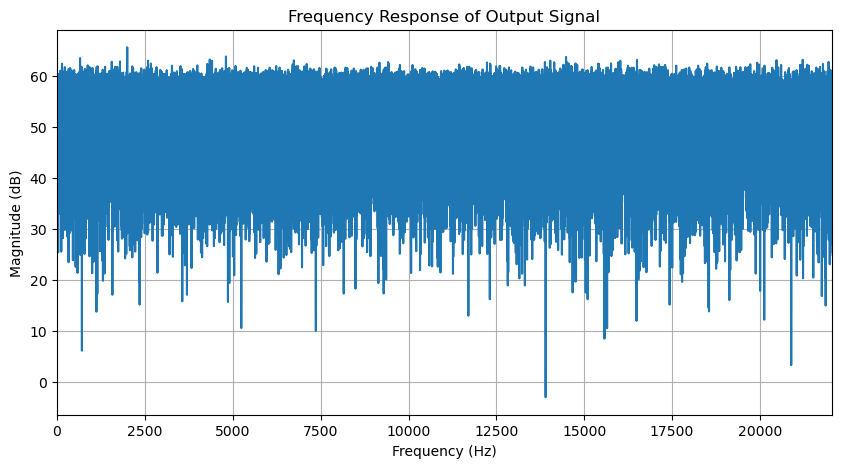

In [29]:
Y = np.fft.fft(x)

# Compute the frequency axis
freq = np.fft.fftfreq(len(x)) * fs

# Plot the magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(freq, 20 * np.log10(np.abs(Y)))
plt.title('Frequency Response of Output Signal')
plt.xlim(0, fs / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

In [30]:
def Shelving(b0, b1, a1, x):
    y = np.zeros(len(x))
    # Iterate over the signal
    for i in range(len(x)):
        if i > 0:
            y[i] = b0 * (x[i] - a1 * x[i-1]) + b1 * x[i-1]
        else:
            y[i] = b0 * x[i]

        # Update x for the next iteration
        #x[i] = y[i]
    
    return y

In [31]:
b0_low, b1_low, a0_low, a1_low, w, h_low = lowShelf(100, 500, fs)
y = Shelving(b0_low/a0_low, b1_low/a0_low, a1_low/a0_low, x)
Audio(data = y * 0.1, rate = fs)

After applying the low shelf filter (with a gain of 100 and a cutoff frequency of 500 Hz), there's a subtle enhancement in low frequencies. While the boost is present, it's not as pronounced as expected. 

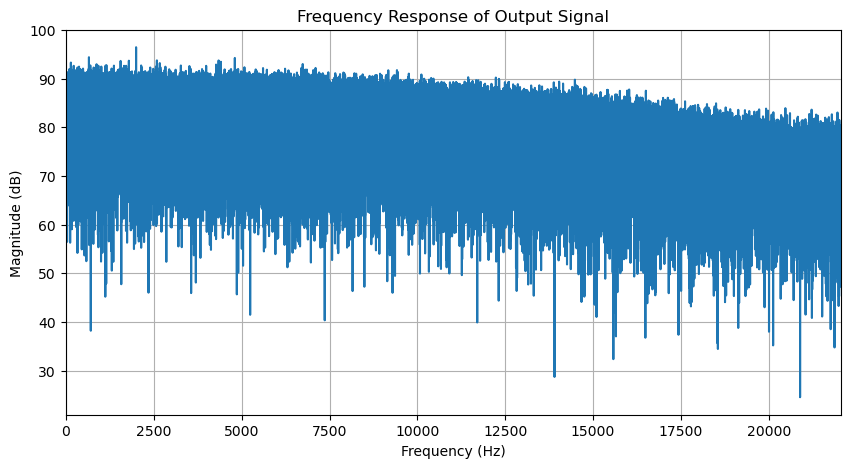

In [32]:
Y = np.fft.fft(y)

# Compute the frequency axis
freq = np.fft.fftfreq(len(y)) * fs

# Plot the magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(freq, 20 * np.log10(np.abs(Y)))
plt.title('Frequency Response of Output Signal')
plt.xlim(0, fs / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

In [33]:
b0_high, b1_high, a0_high, a1_high, w, h_high = highShelf(50, 10000 , fs)
y = Shelving(b0_high/a0_high, b1_high/a0_high, a1_high/a0_high, x)
Audio(data = y * 0.1, rate = fs)

After applying the high shelf filter (with a gain of 50 and a cutoff frequency of 10,000 Hz), you can hear a noticeable increase in high-frequency components.

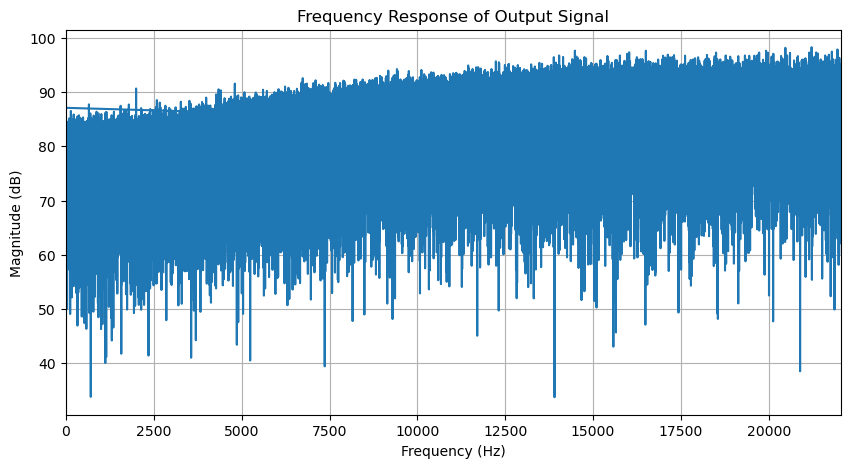

In [34]:
Y = np.fft.fft(y)

# Compute the frequency axis
freq = np.fft.fftfreq(len(y)) * fs

# Plot the magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(freq, 20 * np.log10(np.abs(Y)))
plt.title('Frequency Response of Output Signal')
plt.xlim(0, fs / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

# Reference
[1] Zölzer, Udo. (2011) DAFX : digital audio effects. 2. ed. Chichester: Wiley.

[2] Välimäki, V. & Reiss, J. D. (2016) All about audio equalization.